<script type="text/x-mathjax-config">
MathJax.Hub.Config({
  TeX: { 
    equationNumbers: { autoNumber: "AMS" } 
    }
});
</script>


In [23]:
%%js
MathJax.Hub.Config({
  TeX: { 
    equationNumbers: { autoNumber: "AMS" } 
    }
});


<IPython.core.display.Javascript object>

In [24]:
%pylab inline
rcParams['figure.figsize'] = [7, 6]
rcParams['axes.labelsize'] = 20
from math import pi
from IPython.display import display, Math,Latex
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


c:\program files\python37\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pi', 'table']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Моделирование
## Распределение амплитуд

$\renewcommand{\phi}{\varphi}$
Для моделирования случайной поверхности $\Sigma(\vec{r},t)$ используется ее представление в виде суперпозиции плоских волн (гармоник) с различными частотами $\omega_n$ и случайными фазами $\Psi_{nm}$, бегущих под разными азимутальными углами $\phi_m$:
$$\begin{equation*}
    \Sigma(\vec{r},t)=\sum\limits_{n=1}^N\sum_{m=1}^M A_n
    cos(\omega_nt+\vec{k_n}\vec{r}+\Psi_{nm})\cdot\Phi_{nm}
    (\omega_n,\phi_m)
    \label{eq:1}
\end{equation*}$$
Далее будут приведены основные соотношения, необходимые для этого уравнения

$$\begin{equation}
\begin{cases}
	S_{\Sigma}(\omega) = S_{\xi}, & 0< \omega\leq 1.2\omega_m\\
	S_{\Sigma}(\omega) = \frac{\alpha_2}{\omega^4}, 
	& 1.2\omega<\omega \leq a_m\omega_m\\
	S_{\Sigma}(\omega) = \frac{\alpha_3}{\omega^5}, 
	& a_m\omega_m < \omega \leq \omega_{gk}\approx 64 \text{ рад/с}\\
	S_{\Sigma}(\omega) = \frac{\alpha_4}{\omega^2.7}, 
	& \omega_{gk} < \omega \leq \omega_{h}\approx 298 \text{ рад/с}\\
	S_{\Sigma}(\omega) = \frac{\alpha_5}{\omega^5}, 
	& \omega_h<\omega
\end{cases}
\end{equation}$$
Здесь $$\begin{gather}
S_{\xi}(\omega)=\alpha g^2\omega^{-5}\exp\{-1.25(\frac{\omega_m}{\omega})^4\cdot\gamma^r\} \\
r=\exp\left\{-(\omega-\omega_m)^2/(2\sigma_*^2\omega_m^2) \right\}
\end{gather}$$


--спектр JONSWAP.

\begin{equation}
k_m=0.697\cdot \frac{g}{U_{10}^2},
\end{equation} g-ускорение свободного падения
Насколько я понимаю, то $\omega_m$ однозначно связана с $k_m$ соотношением 
\begin{equation}
k_m=\frac{\omega_m^2}{g}
\end{equation}

Таким образом, частоту спектрального пика $\omega_m$ мы определяем как:
\begin{equation}
\omega_m^2=0.697\cdot \frac{g^2}{U_{10}^2} .
\end{equation}

In [25]:
global g,omega_gk,omega_h #объявление постоянных величин, которые встречаются во множестве формул
x=20170
g=9.81
omega_gk=64
omega_h=298   

def omega_max(U10):
    omega=0.697**(1/2)*g/U10
    return omega

def k_max(U10):
    k_max=0.697*g/U10**2
    return k_max

def omega_k(k): # Пересчет волнового числа в частоту по полному дисперсионному
#     omega_k=(g*k)**(1/2) #Простое дисперсионное
    omega_k=(g*k+0.0748*k**3/1000)**(1/2) #Сложное дисперсионное
    return omega_k



def omega(x, U10):
    omega=g*omega_tilde(x)/U10
    return omega

Бля, как же тяжело писать спустя месяц

Значение коэффициента $a_m$ зависит от скорости ветра:

In [26]:
def a(U10):
    a=0.371+0.29*U10+0.29/U10
    return a

Коэффициенты $\alpha_i$ вычисляются по следующей формуле:

In [27]:
def alpha0(U10,x):
    omega_m=omega_max(U10)
    alpha=np.zeros(6)
    alpha[2]=S0(1.2*omega_m,U10,x)*(1.2*omega_m)**4
    alpha[3]=alpha[2]*a(U10)*omega_m
    alpha[4]=alpha[3]/omega_gk**(2.3)
    alpha[5]=alpha[4]*omega_h**(2.3)
    return alpha

Зададим спектр JONSWAP

Стоит также сказать о коэффициентах $\alpha$ и $\gamma$, входящие в спектр JONSWAP. Они зависят от безразмерного коэффициента разгона $\bar{x} \in [1400,20170]$

А $\sigma_*$, входящее в $r$, задаётся как:

$$\sigma_*=
\begin{cases}
0.07, & \omega\leq\omega_m \\
0.09, & \omega>\omega_m
\end{cases}
$$


In [28]:
def Sigma(omega):
    omega_m=omega_max(U10)
    if omega <= omega_m:
        return 0.07
    else:
        return 0.09

In [29]:
def Alpha(x):
    alpha=array([],dtype='float64')
    alpha=[( 
           +0.0311937
           -0.00232774*log(x)
           -8367.8678786/x**2
#            +4.5114599e+300*exp(-x)*1e+300*1e+17
           +4.5114599e+17*exp(-x)
          )]
    return alpha[0]
def Gamma(x):
    gamma=(
           +5.253660929
           +0.000107622*x
           -0.03778776*sqrt(x)
           -162.9834653/sqrt(x)
           +253251.456472*x**(-3/2)
          )
    return gamma

def Omega_m(x): #Вычисление безразмерной частоты по безразмерному разгону
    omega_tilde=0.6182636+3.52883*10**(-6)*x-0.00197508*(x)**(1/2)-290.214121/x
    return omega_tilde

Нашёл ошибку в коде. В оригинальной программе частота выражалась через безразмерную частоту. 

In [48]:
def S0(k,U10,x):
    omega=omega_k(k)
    omega_m=omega_max(U10)
    
    def r(omega,omega_m):
        r=(np.exp(-(omega-omega_m)**2/(2*sigma**2*omega_m**2)))
        return r
    
    alpha=Alpha(x)
#     alpha=0.081
    gamma=Gamma(x)
#     gamma=3.3
    sigma=Sigma(omega)
    a_m=a(U10)
    S0=( #Вот тут заменить на омегу~
        alpha *  g**2 * omega**(-5)
        *exp(-1.25*(omega_m/omega)**4)*
        gamma**r(omega,omega_m)
    )
    return S0



Спектр JONSWAP через k

In [49]:
# def S0(k,U10,x):
#     k_m=k_max(U10)
    
#     def r(omega,omega_m):
#         r=(np.exp(-( (k/k_m-1)**(1/2) )**2/(2*sigma**2*omega_m**2)))
#         return r
    
#     alpha=Alpha(x)
# #     alpha=0.081
#     gamma=Gamma(x)
# #     gamma=3.3
#     sigma=Sigma(omega)
#     a_m=a(U10)
#     S0=(
#         alpha/2 * k**(-3)
#         *exp(-1.25*(k_m/k)**2)*
#         gamma**r(omega,omega_m)
#     )
#     return S0

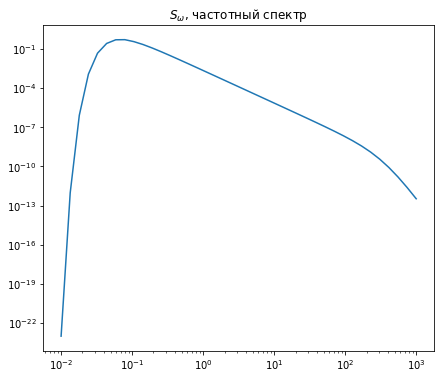

In [54]:
U10=10
y=[]
k=logspace(-2,3,10*4)
for i in k:
    y.append(S0(i,U10,x))
    
loglog(k,y)
title('$S_{\omega}$, частотный спектр')
show()
# plot(k,y)
# title('$S_k$ спектр')
# show()
# lam=2*pi/k
# y=[y[i] for i in argsort(lam)]
# lam=sort(lam)
# plot(lam[0:argmax(y)+350],y[0:argmax(y)+350])
# title('$S_{\lambda}$ спектр')
# show()


In [32]:
def S(k,U10,x):
    omega=omega_k(k)
    omega_m=omega_max(U10)
 
    alpha=alpha0(U10,x)
    
    if 0<=omega<=1.2*omega_m:
        S=S0(omega,U10,x)
    elif 1.2*omega_m<omega<=a(U10)*omega_m:
        S=alpha[2]/omega**4
    elif a(U10)*omega_m<omega<=omega_gk:
        S=alpha[3]/omega**5
    elif omega_gk<omega<=omega_h:
        S=alpha[4]/omega**(2.7)
    elif omega_h<omega:
        S=alpha[5]/omega**5
        
    return S

<script type="text/x-mathjax-config">
MathJax.Hub.Config({
  TeX: { equationNumbers: { autoNumber: "AMS" } }
});
</script>

## Контрольная точка. Проверка спектра амплитуд

### При постоянном X и меняющейся скорости ветра

Ниже построены графики зависимости $S_{\omega}(\omega)$

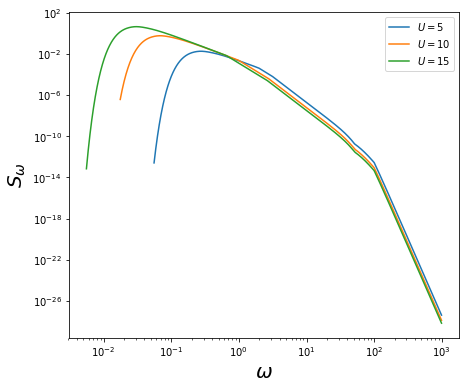

In [33]:
x=30000
U10=5
k=logspace(-3.5,5,1000)
C=[]
for i in k:
    C.append(S(i,U10,x))
loglog(sqrt(k*g),C,label='$U=5$')

U10=10
k=logspace(-4.5,5,1000)
C=[]
for i in k:
    C.append(S(i,U10,x))
loglog(sqrt(k*g),C,label='$U=10$')

U10=15
k=logspace(-5.5,5,1000)
C=[]
for i in k:
    C.append(S(i,U10,x))
loglog(sqrt(k*g),C,label='$U=15$')
legend()
xlabel('$\omega$')
ylabel('$S_{\omega}$')
show()

### При постоянной скорости и меняющемся X

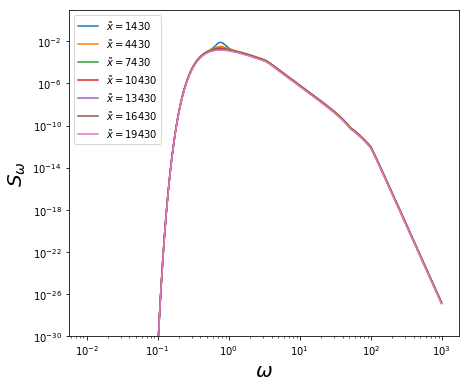

In [34]:
xx=arange(1430,20000,3000)
U10=3
for n in xx:
    x=n
    k=logspace(-5,5,1000)
    C=[]
    for i in k:
        C.append(S(i,U10,x))
    loglog(sqrt(k*g),C,label='$\\~{x}=$'+'{0}'.format(x))

ylim([10**-30,10])
xlabel('$\omega$')
ylabel('$S_{\omega}$')
legend()

In [35]:
row1=['$\\alpha$']
row2=['$\\gamma$']
for i in xx:
    row1.append(Alpha(i))
    row2.append(Gamma(i))
    
from ipy_table import make_table
xx=xx.tolist()
xx.insert(0,'x')
table=[xx,row1,row2]
make_table(table)

x,1430,4430,7430,10430,13430,16430,19430
$\alpha$,0.0102,0.0112,0.0103,0.0096,0.0090,0.0086,0.0082
$\gamma$,4.3519,1.6255,1.3007,1.1589,1.0762,1.0270,1.0017


Тоже самое, но в увеличенном виде

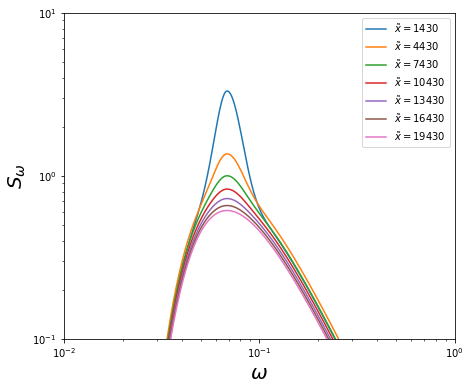

In [36]:
xx=arange(1430,20000,3000)
U10=10
for n in xx:
    x=n
    k=logspace(-5,5,1000)
    C=[]
    for i in k:
        C.append(S(i,U10,x))
    loglog(sqrt(k*g),C,label='$\\~{x}=$'+'{0}'.format(x))
xlabel('$\omega$')
ylabel('$S_{\omega}$')
ylim([10**-1,10])
xlim([10**-2,1])
legend()

Для сравнения, можно построить график из готовых данных

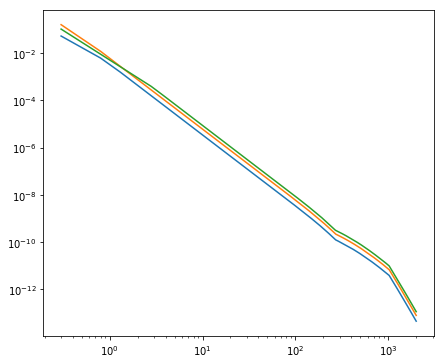

In [51]:
name='u5.dat'
data=pd.read_csv(name,sep='\s+')
KT=array(data['KT'])
OUR=array(data['OUR'])
loglog(KT,OUR)

name='u10.dat'
data=pd.read_csv(name,sep='\s+')
KT=array(data['KT'])
OUR=array(data['OUR'])
loglog(KT,OUR)

name='u15.dat'
data=pd.read_csv(name,sep='\s+')
KT=array(data['KT'])
OUR=array(data['OUR'])
loglog(KT,OUR)

In [38]:
# loglog(data['WT'],data['OUR'])

## Угловое распределение
Угловое распределение $\Phi_{\omega}$ описывается следующей формулой:
$$\Phi_{\omega}=A\cdot\frac{2}{\exp(2B\phi)+\exp(-2B\phi)}=\frac{A}{\cosh(2B\phi)},\, -\pi\leq\phi\leq\pi$$
Где $B=10^b$, а b описывается следующей формулой:
$$b=-0.28+0.65\exp\left\{-0.75\log(\frac{k}{k_m})\right\}+0.01\exp\left\{0.2+0.7\lg(\frac{k}{k_m})\right\}$$

<IPython.core.display.Math object>

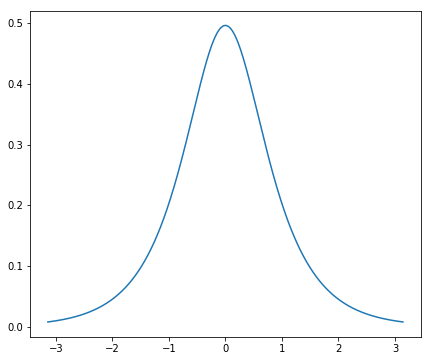

In [39]:

def Phi(phi, omega,U10):
    def B(omega,U10):
        def b(omega, U10):
            k_m=k_max(U10)
            k=omega**2/g
            b=-0.28+0.65*exp(-0.75*log(k/k_m))+0.01*exp(0.2+0.7*log10(k/k_m))            
            return b
        B=10**b(omega,U10)
        return B
    def A(B):
        A=B/arctan(sinh(2*pi*B))
        return A
    
    B=B(omega,U10)
    
    A=A(B)
    Phi=A/cosh(2*B*phi)
    return Phi

x=linspace(-pi,pi,1000)
y=Phi(x,60,10)
plot(x,y)

integral=trapz(y,x,dx=0.1)
display(Math
    (
     r'Интеграл\,функции\,распределения:\\'
     +'\displaystyle\int\limits_{-\pi}^{\pi}'
     +'\Phi_{\omega}(\omega,\phi)d\phi'
     +'={0} \simeq  {1}'.format(integral,round(integral,3)) 
    )
       )

In [40]:
def A(omega,n,U10,x):
    A=sqrt(2*(n*omega-(n-1)*omega)*S0(omega,U10,x))
    return A

def Phi0(phi,omega,U10):
    Phi0=sqrt(2*pi/100* Phi(phi,omega,U10) )
    return Phi0

$\Phi_{nm}$ имеет вид:

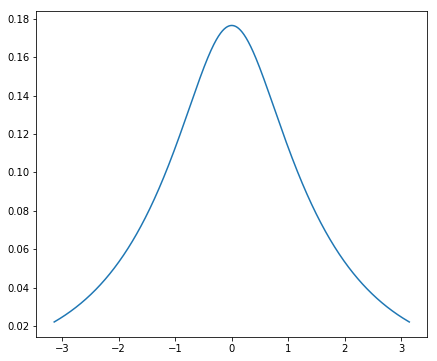

In [41]:
x=linspace(-pi,pi,1000)
y=Phi0(x,60,10)
plot(x,y)

$A_n$ имеет вид:

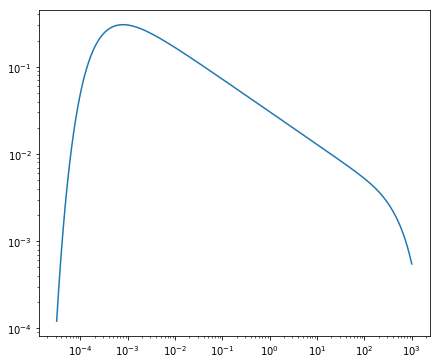

In [42]:
k=logspace(-4.5,3,1000)
omega=omega_k(k)
y=[]
x_=20170
for x in omega:
    y.append(A(x,6,10,x_))
loglog(k,y)

Остается вопрос как на основе скорости ветра и безразмерного разгона выбрать волновое число

In [43]:
# %matplotlib qt
def model(k,U10,t,x,psi,x_):
    N=int(200*U10)
    model=0
    phi=linspace(0,2*pi,100)
    for j in range(1,N):
        omega=j*omega_k(k)
#     for m in range(1,100):
        model+=(
                A(omega,j,U10,x_)*cos(omega*t+x*k*j+psi[j])
#                 *Phi0(phi[m],omega,U10)
               )
    return model

def psi(U10):
    N=int(200*U10)
    psi=zeros(N)
    for j in range(N):
        psi[j]=random.uniform(0,2*pi)
    return psi

U10=10
# print(k_max(U10))
phase=psi(U10)
# print(phase)

# x=linspace(0.001,400,1000)
x=arange(0.01,4,0.01)
x_=20170
Model=zeros(len(x))
t=10
for i in range(1,len(x)):
    Model[i]=(model(2,U10,0,x[i],phase,x_))
plot(x[0:-1],Model[0:-1])
show()

dispersion=std(Model)
mn=mean(Model)
med=median(Model)
print('Дисперсия=',dispersion)
print('Среднее=',mn)
print('Медианное значение=',med)